In [3]:
import kagglehub
import os
import pandas as pd
import cv2
import os
# from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import shutil
from PIL import Image
import tensorflow as tf

RANDOM_STATE = 32
VALIDATION_SPLIT = 0.2



In [4]:
# Download latest version
cache_path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

print("Path to dataset files:", cache_path)

Path to dataset files: C:\Users\gabri\.cache\kagglehub\datasets\kmader\skin-cancer-mnist-ham10000\versions\2


In [5]:
for item in os.scandir(cache_path):
    print(f"{item.name} - {'Directory' if item.is_dir() else 'File'} - Size: {os.path.getsize(item.path)} bytes")


HAM10000_images_part_1 - Directory - Size: 2359296 bytes
HAM10000_images_part_2 - Directory - Size: 2359296 bytes
HAM10000_metadata.csv - File - Size: 563277 bytes
hmnist_28_28_L.csv - File - Size: 30807979 bytes
hmnist_28_28_RGB.csv - File - Size: 91820383 bytes
hmnist_8_8_L.csv - File - Size: 2537778 bytes
hmnist_8_8_RGB.csv - File - Size: 7524968 bytes


In [ ]:
# ls {cache_path} -l

Based on https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000/data, the HAM10000_metadata.csv file lists all images in the dataset, including information such as lesion id, image file name, age of patient, skin cancer type, etc. Each image file are stored in one of either two subfolders - i.e. HAM10000_images_part_1 and HAM10000_images_part_2.

We will create a new directory where: <br>
> (1) all images are copied to 'input' folder<br>
> (2) the metadata.csv is copied, <br>
> (3) preprocessed images are stored are placed in 'output' folder

In [ ]:
# # define directories for EDA/Preprocessing
# DIR = '/content/skin_cancer/eda_preprocess'
# INPUT_DIR = DIR + '/input'
# OUTPUT_DIR = DIR + '/output'

# # create directories for input images, and output (preprocessed) images
# os.makedirs(DIR, exist_ok=True)
# os.makedirs(INPUT_DIR, exist_ok=True)
# os.makedirs(OUTPUT_DIR, exist_ok=True)

# # copy images from the cache (both part1 and 2 folders) to the target_path/images
# !cp {cache_path+'/HAM10000_images_part_1/*'} {INPUT_DIR} -r
# !cp {cache_path+'/HAM10000_images_part_2/*'} {INPUT_DIR} -r

# # copy metadata onto target_path
# !cp {cache_path+'/HAM10000_metadata.csv'} {DIR}

# # remove all files from the cache
# #!rm -rf {cache_path}

In [6]:
import shutil
import glob

# Define directories for EDA/Preprocessing
DIR = '/content/skin_cancer/eda_preprocess'
INPUT_DIR = os.path.join(DIR, 'input')
OUTPUT_DIR = os.path.join(DIR, 'output')

# Create directories for input images and output (preprocessed) images
os.makedirs(INPUT_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Copy images from the cache to the target input directory
image_parts = [os.path.join(cache_path, 'HAM10000_images_part_1', '*'),
               os.path.join(cache_path, 'HAM10000_images_part_2', '*')]

for part in image_parts:
    for file in glob.glob(part):
        shutil.copy(file, INPUT_DIR)

# Copy metadata to the target directory
metadata_src = os.path.join(cache_path, 'HAM10000_metadata.csv')
metadata_dest = os.path.join(DIR, 'HAM10000_metadata.csv')
shutil.copy(metadata_src, metadata_dest)

print("Files copied successfully!")

Files copied successfully!


 Read the metadata csv into a pandas df and view the first few rows of data.

In [8]:
# read metadata into a pandas df
metadata_df = pd.read_csv(DIR + '/HAM10000_metadata.csv')
metadata_df.head(7)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face


In [9]:
# describe
metadata_df.describe(include='all')

,lesion_id,image_id,dx,dx_type,age,sex,localization
count,10015,10015,10015,10015,9958.000000,10015,10015
unique,7470,10015,7,4,NaN,3,15
top,HAM_0003789,ISIC_0027419,nv,histo,NaN,male,back
freq,6,1,6705,5340,NaN,5406,2192
mean,NaN,NaN,NaN,NaN,51.863828,NaN,NaN
std,NaN,NaN,NaN,NaN,16.968614,NaN,NaN
min,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,40.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,50.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,65.000000,NaN,NaN


**COMMENTS:**
> (1) There are 10015 images available in this dataset <br>

> (2) However, there are only 7470 unique lesions. This implies that two or more images may point to the same lesion. **Investigate further.** <br>

> (3) 'dx' shows 7 unique values across 10015 images, which is consistent with the column description from the kaggle website:
"Cases include a representative collection of all important diagnostic categories in the realm of pigmented lesions: <br>
>> (a) ***akiec*** : Actinic keratoses and intraepithelial carcinoma / Bowen's disease, <br>
>> (b) ***bcc*** : basal cell carcinoma, <br>
>> (c) ***bkl*** : benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses)<br>
>> (d) ***df*** : dermatofibroma, <br>
>> (e) ***mel*** : melanoma,<br>
>> (f) ***nv*** : melanocytic nevi, and <br>
>> (g) ***vasc*** : vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage)."<br>

> (4) 'dx_type' tells us how the 'dx' (ground truth) was decided for each lesion in the dataset. The possible values are:
>> (a) ***histo*** : confirmed through histopathology, <br>
>> (b) ***follow_up*** : via follow-up examination, <br>
>> (c) ***consensus*** : via expert consensus, and <br>
>> (d) ***confocal*** : confirmation by in-vivo confocal microscopy."

> (5) 'age' is a numerical variable but it showing NaN in unique counts. This implies that there are images with no 'age' values. **Investigate further**<br>

> (6) 'sex' shows 3 unique values suggesting possible missing values <br>


**STEP 1: FIND AND REMOVE ENTRIES WITH NULL VALUES**

In [10]:
# Find entries with NULL
metadata_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

**Comment:**
> Either we drop the 'Age' column entirely, or we drop the entries with no 'Age' value in them. <br>

> For now, we will remove entries with no Age value. **CHECK AGAIN LATER** <br>


In [11]:
metadata_df = metadata_df.dropna().reset_index(drop=True)
metadata_df.isnull().sum()
len(metadata_df)

9958

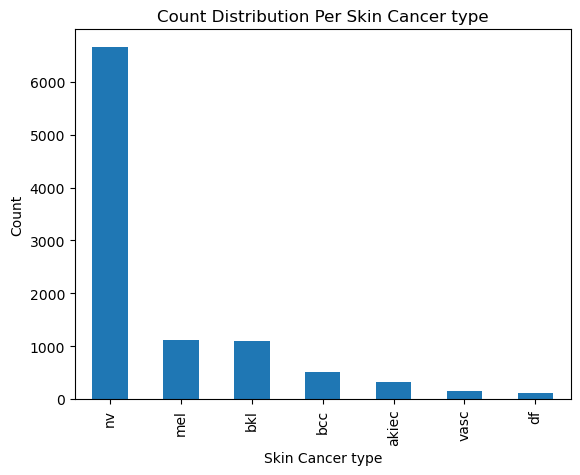

In [12]:
# Show Count Distribution for Skin Cancer type ('dx')
metadata_df['dx'].value_counts().plot(kind='bar')
plt.title('Count Distribution Per Skin Cancer type')
plt.xlabel('Skin Cancer type')
plt.ylabel('Count')
plt.show()

**STEP 2: PERFORM EDA on LESION vs IMAGES**

In [13]:
def disp_images(image_ids= []):
  # displays images listed in 'image_ids'.
  max_cols = 3
  num_imgs = len(image_ids)
  num_rows = (num_imgs - 1) // max_cols + 1
  num_cols = min(num_imgs, max_cols)
  plt.figure(figsize=(10, 5))
  for i, image_id in enumerate(image_ids):
    image = cv2.imread(INPUT_DIR + '/' + image_id + '.jpg')
    plt.subplot(num_rows, num_cols, i+1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(image_id)
    plt.axis('off')

  plt.show()

def disp_lesion(lesion_id):
  # displays all images associated to the specified lesion_id
  lesionX_imgs = metadata_df[metadata_df['lesion_id']==lesion_id]['image_id'].tolist()
  disp_images(lesionX_imgs)


In [14]:
# List some lesions with multiple associated images, and check whether any of the images are duplicates
lesion_counts = metadata_df['lesion_id'].value_counts()
lesion_counts.head(10)

lesion_id
HAM_0000835    6
HAM_0003789    6
HAM_0005263    6
HAM_0001863    6
HAM_0007367    5
HAM_0007427    5
HAM_0007343    5
HAM_0000893    5
HAM_0002364    5
HAM_0004621    4
Name: count, dtype: int64

In [15]:
# show metadata for HAM_0000835
metadata_df[metadata_df['lesion_id']=='HAM_0000835']

,lesion_id,image_id,dx,dx_type,age,sex,localization
807,HAM_0000835,ISIC_0025378,bkl,confocal,55.0,female,face
808,HAM_0000835,ISIC_0030394,bkl,confocal,55.0,female,face
818,HAM_0000835,ISIC_0027270,bkl,confocal,55.0,female,face
820,HAM_0000835,ISIC_0031329,bkl,confocal,55.0,female,face
868,HAM_0000835,ISIC_0026530,bkl,confocal,55.0,female,face
870,HAM_0000835,ISIC_0024409,bkl,confocal,55.0,female,face


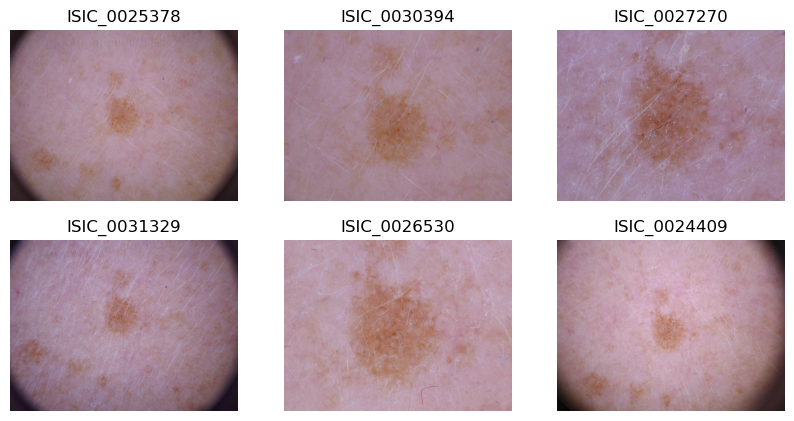

In [16]:
# display all images associated to a specified lesion_id
lesion_id = 'HAM_0000835'
disp_lesion(lesion_id)

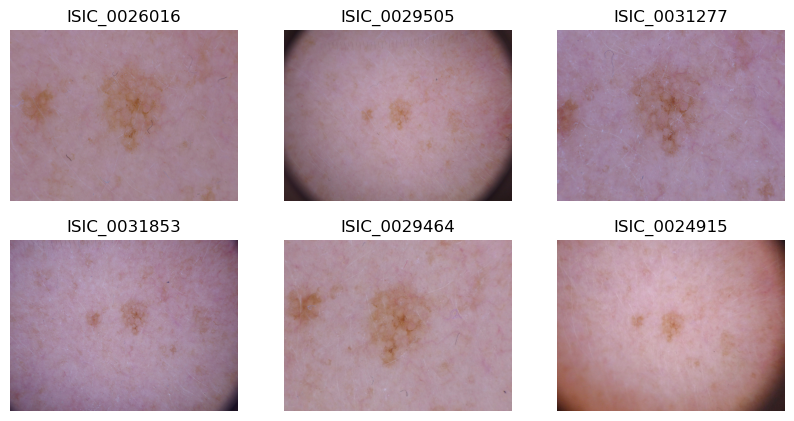

In [17]:
# Try on another lesion with 6 associated images
lesion_id = 'HAM_0003789'
disp_lesion(lesion_id)

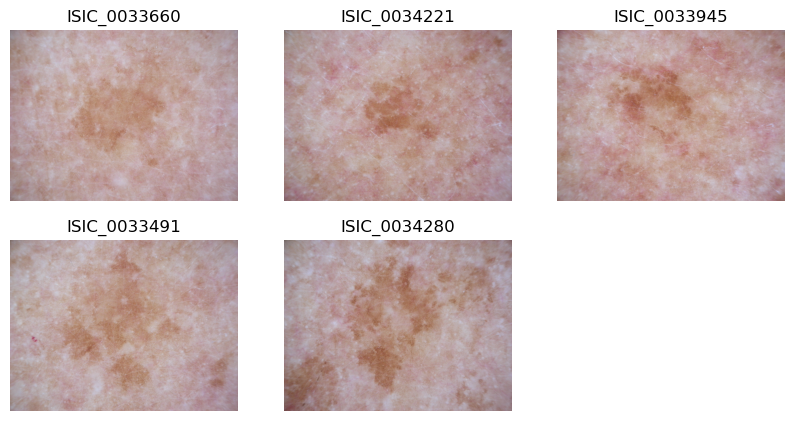

In [18]:
# try on another with 5 associated images
lesion_id = 'HAM_0007427'
disp_lesion(lesion_id)

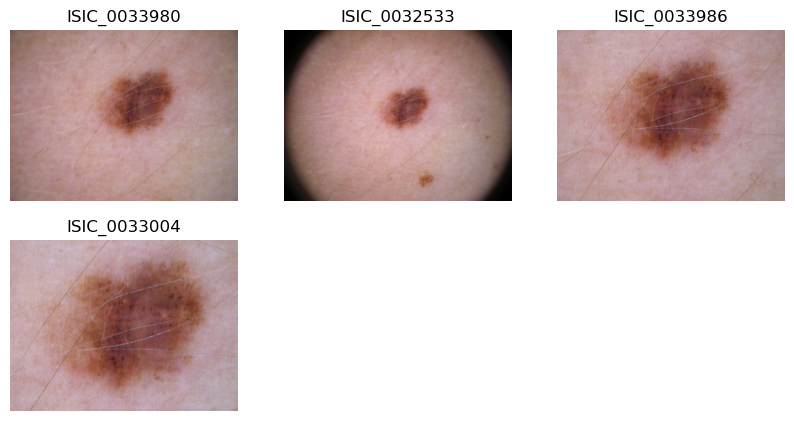

In [19]:
# try on another lesion with 4 associated images
lesion_id = 'HAM_0003602'
disp_lesion(lesion_id)

In [20]:
lesion_counts.value_counts()

count
1    5467
2    1418
3     490
4      34
5       5
6       4
Name: count, dtype: int64

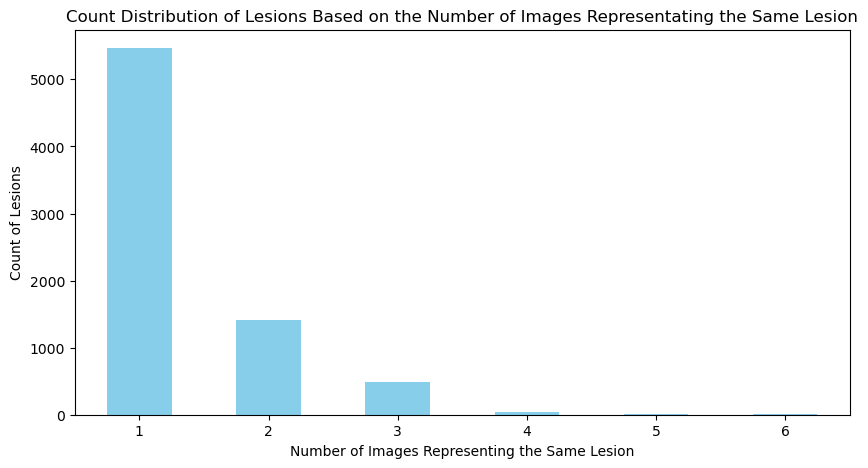

In [21]:
plt.figure(figsize=(10, 5))
lesion_counts.value_counts().plot(kind='bar', color='skyblue')
plt.xlabel('Number of Images Representing the Same Lesion')
plt.ylabel('Count of Lesions')
plt.title('Count Distribution of Lesions Based on the Number of Images Representating the Same Lesion')
plt.xticks(rotation=0)  # Rotate x-axis labels if necessary
plt.show()

In [22]:
total = np.sum(lesion_counts.value_counts())
total

7418

**COMMENT:**

> After removing entries with NULL, there are now 7418 unique lesions in the dataset.<br>

> 5467 of these have only one associated image each.<br>

> For each of the remaining 1951 lesions, the associated images appear to be of the same lesion but with varying zoom levels.<br>


**STEP N: ADD OTHER EDAs HERE, and any PREPROCESSING if FOUND NECESSARY**
> 'dx' class imbalance requires stratification during test/train split

**STEP 3: SPLIT INTO TRAIN/VAL Sets**

> The validation set must be created from the set of 5467 lesions with only one associated image each. We don't want zoomed images of the same lesion to appear on both the validation and the training sets.


In [23]:
# drop rows from metadata_df with duplicated 'lesion_id' values
metadata_df_wNo_aug = metadata_df.drop_duplicates(subset='lesion_id', keep=False)
metadata_df_wNo_aug.head()

# print initial settings
print("Num Lesions with No Augmentation: ", len(metadata_df_wNo_aug),"\n")
print(f"Validation Split: {VALIDATION_SPLIT*100}% of lesions with no augmented images = {VALIDATION_SPLIT*len(metadata_df_wNo_aug)}\n")
print(f"Random State: {RANDOM_STATE}\n")

# split df with no augmentation to generate validation set
# make sure the split is stratified based on the 'dx' class because of class imbalance as shown in earlier EDA
_, metadata_df_val = train_test_split(metadata_df_wNo_aug, test_size=0.20, random_state=RANDOM_STATE, stratify = metadata_df_wNo_aug['dx'])
metadata_df_val.reset_index(drop=True, inplace=True)

# print sample count per skin cancer type and total
counts = metadata_df_val['dx'].value_counts()
total = counts.sum()
counts_with_total = pd.concat([counts, pd.Series({'TOTAL': total})])
print("Sample Count Per Skin Cancer Type (VALIDATION SET)\n")
print(counts_with_total,"\n")

Num Lesions with No Augmentation:  5467 

Validation Split: 20.0% of lesions with no augmented images = 1093.4

Random State: 32

Sample Count Per Skin Cancer Type (VALIDATION SET)

nv        876
bkl        86
mel        46
bcc        35
akiec      30
vasc       13
df          8
TOTAL    1094
dtype: int64 



> Next we create the metadata for training. We simply remove the lesions in the validation data set from the master dataset.

In [24]:
# create list of lesion_id's from the validation metadata df
lesion_ids_val = metadata_df_val['lesion_id'].tolist()

# from the metadata df, drop lesions that are already included in the validation list
metadata_df_train = metadata_df[~metadata_df['lesion_id'].isin(lesion_ids_val)]
metadata_df_train.reset_index(drop=True, inplace=True)

# print sample count per skin cancer type and total
counts = metadata_df_train['dx'].value_counts()
total = counts.sum()
counts_with_total = pd.concat([counts, pd.Series({'TOTAL': total})])
print("Sample Count Per Skin Cancer Type (TRAINING SET)\n")
print(counts_with_total,"\n")

Sample Count Per Skin Cancer Type (TRAINING SET)

nv       5784
mel      1065
bkl      1003
bcc       479
akiec     297
vasc      129
df        107
TOTAL    8864
dtype: int64 



> Save the metadata for training and validation sets into separate folders in OUTPUT_DIR

In [25]:
# create train and val subdirectories in OUTPUT_DIR
OUTPUT_DIR_TRAIN = OUTPUT_DIR + '/train'
OUTPUT_DIR_VAL = OUTPUT_DIR + '/val'
os.makedirs(OUTPUT_DIR_TRAIN, exist_ok=True)
os.makedirs(OUTPUT_DIR_VAL, exist_ok=True)

# save the train/val metadata dfs into respective files
metadata_df_train.to_csv(OUTPUT_DIR_TRAIN+'/metadata_train.csv', index=False)
metadata_df_val.to_csv(OUTPUT_DIR_VAL+'/metadata_val.csv', index=False)

In [26]:
# list 'dx' types and create directories for each of them under OUTPUT_DIR_TRAIN
dx_types = metadata_df_train['dx'].unique()
for dx_type in dx_types:
  os.makedirs(OUTPUT_DIR_TRAIN+'/'+dx_type, exist_ok=True)

# move each image from the training set into their own 'dx' type folder
for i in range(0,len(metadata_df_train)):
  if(i%1000==0): print("sample i: ", i)
  image_id = metadata_df_train['image_id'][i]
  dx_type = metadata_df_train['dx'][i]

  source = os.path.join(INPUT_DIR, image_id+'.jpg')  # Path to the source file
  destination = os.path.join(OUTPUT_DIR_TRAIN+'/'+dx_type, image_id+'.jpg')
  shutil.move(source, destination)

#shutil function is so much faster than CLI copy. However, references to the old images are gone.

sample i:  0
sample i:  1000
sample i:  2000
sample i:  3000
sample i:  4000
sample i:  5000
sample i:  6000
sample i:  7000
sample i:  8000


In [27]:
# Do the same with the validation set
# list 'dx' types and create directories for each of them under OUTPUT_DIR_TRAIN
dx_types = metadata_df_val['dx'].unique()
for dx_type in dx_types:
  os.makedirs(OUTPUT_DIR_VAL+'/'+dx_type, exist_ok=True)

for i in range(0,len(metadata_df_val)):
  if(i%100==0): print("sample i: ", i)
  image_id = metadata_df_val['image_id'][i]
  dx_type = metadata_df_val['dx'][i]

  source = os.path.join(INPUT_DIR, image_id+'.jpg')  # Path to the source file
  destination = os.path.join(OUTPUT_DIR_VAL+'/'+dx_type, image_id+'.jpg')
  shutil.move(source, destination)

sample i:  0
sample i:  100
sample i:  200
sample i:  300
sample i:  400
sample i:  500
sample i:  600
sample i:  700
sample i:  800
sample i:  900
sample i:  1000


**STEP 4: RESIZE IMAGES**

In [28]:
# EDA on TRINING IMAGE SHAPES
shapes = []

# get image shapes in train_ds
shapes = []
image_count =0
for root, dirs, files in os.walk(OUTPUT_DIR_TRAIN):
  for filename in files:
     if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
        image_path = os.path.join(root, filename)
        # Process the image here
        with Image.open(image_path) as img:
              shapes.append(img.size)
        #print(f"Processing image: {image_path}")
        print(f"Processing image {image_count}", end='\r')
        image_count += 1

print(f"Total images: {len(shapes)}")

# show shape count/distribution
shape_distribution = np.unique(shapes, return_counts=True)
print(f"Image Shape Distribution: {shape_distribution}")

Total images: 8864863
Image Shape Distribution: (array([450, 600]), array([8864, 8864], dtype=int64))


In [29]:
# Set common parameters
TARGET_SIZE = (256,256) #  resize image to reduce complexity ((224,224) for ViT; (256,256)for YOLO )
BATCH_SIZE = 32
RANDOM_SEED = 42

In [30]:
# define function to resize images in a directory to a specified size
# and saves resulting images to a target directory
def resize_images(source_dir, target_dir):

  # generate resized image dataset using keras
  images_ds = tf.keras.utils.image_dataset_from_directory(
    source_dir,
    seed=RANDOM_SEED,
    image_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    crop_to_aspect_ratio=False, # prevents cropping
    # This approach will resize the images while preserving their aspect ratio,
    # avoiding distortion or loss of important visual information1.
    # For skin cancer images, maintaining the original proportions is crucial for accurate diagnosis and analysis.
    interpolation="bilinear" # smooth resizing
  )

  # create subdirectories in target directory for resized images
  for dx_type in images_ds.class_names:
    os.makedirs(target_dir+'/'+dx_type, exist_ok=True)

  # save resized images from images_ds into their respective dx type
  image_num = 0
  for batch, labels in images_ds:
    for i, img in enumerate(batch):
        # Convert the tensor to a numpy array
        img_array = (img.numpy()).astype('uint8')

        # get dx type
        dx_type = images_ds.class_names[np.argmax(labels[i])]

        # Generate a filename
        filename = f'image_{image_num}.jpg'

        # log
        #print(f'i:{i} IMAGE_NO:{image_num} LABEL:{dx_type} FILENAME:{filename}')

        image_num += 1

        # Save Path
        save_dir = os.path.join(target_dir, dx_type)
        filepath = os.path.join(save_dir, filename)

        # remove file if it exists
        if os.path.exists(filepath):
          os.remove(filepath)

        tf.keras.utils.save_img(
            filepath,
            img_array,
            scale=False  # We've already scaled the image

        )

In [31]:
RESIZED_DIR_TRAIN = OUTPUT_DIR + '/train_resized'
RESIZED_DIR_VAL = OUTPUT_DIR + '/val_resized'

# resize validation set
resize_images(OUTPUT_DIR_VAL, RESIZED_DIR_VAL)

# resize training set
resize_images(OUTPUT_DIR_TRAIN, RESIZED_DIR_TRAIN)

Found 1094 files belonging to 7 classes.
Found 8864 files belonging to 7 classes.


In [32]:
from PIL import Image
import os

def resize_image(input_path, output_size):
    # Open the image file
    with Image.open(input_path) as img:
        # Resize the image
        img_resized = img.resize(output_size)

        # Save the resized image with the same filename
        img_resized.save(input_path)  # Overwrites the original file

In [33]:
# Iterate through all directories and files
for dirpath, dirnames, filenames in os.walk(OUTPUT_DIR_TRAIN):
    for filename in filenames:
        if filename.endswith(('.png', '.jpg', '.jpeg')):  # Check for image file types
            image_path = os.path.join(dirpath, filename)
            try:
                resize_image(image_path, (256,192))
                #img.show()  # Display the image (optional)
                # Perform any other processing here
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")

In [34]:
# Iterate through all directories and files
for dirpath, dirnames, filenames in os.walk(OUTPUT_DIR_VAL):
    for filename in filenames:
        if filename.endswith(('.png', '.jpg', '.jpeg')):  # Check for image file types
            image_path = os.path.join(dirpath, filename)
            try:
                resize_image(image_path, (256,192))
                #img.show()  # Display the image (optional)
                # Perform any other processing here
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")

**STEP 5: SAVE RESIZED TRAIN & VALIDATION IMAGES TO local folder**

In [35]:
import shutil
import os

# Define source and destination directories
RESIZED_DIR_TRAIN = OUTPUT_DIR + '/train_resized'
RESIZED_DIR_VAL = OUTPUT_DIR + '/val_resized'

LOCAL_SAVE_DIR_TRAIN = 'C:\MSAAI\AAI-521\Final Project Data\YOLO Model Data\Training Data'  # Update this path
LOCAL_SAVE_DIR_VAL = 'C:\MSAAI\AAI-521\Final Project Data\YOLO Model Data\Validation Data'  # Update this path

# Ensure destination directories exist
os.makedirs(LOCAL_SAVE_DIR_TRAIN, exist_ok=True)
os.makedirs(LOCAL_SAVE_DIR_VAL, exist_ok=True)

# Copy Resized Training Images
print("Copying resized training images...")
for dirpath, dirnames, filenames in os.walk(RESIZED_DIR_TRAIN):
    for filename in filenames:
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            source_path = os.path.join(dirpath, filename)
            # Preserve class folder structure
            relative_path = os.path.relpath(dirpath, RESIZED_DIR_TRAIN)
            destination_dir = os.path.join(LOCAL_SAVE_DIR_TRAIN, relative_path)
            os.makedirs(destination_dir, exist_ok=True)
            shutil.copy(source_path, destination_dir)
print("Resized training images saved!")

# Copy Resized Validation Images
print("Copying resized validation images...")
for dirpath, dirnames, filenames in os.walk(RESIZED_DIR_VAL):
    for filename in filenames:
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            source_path = os.path.join(dirpath, filename)
            # Preserve class folder structure
            relative_path = os.path.relpath(dirpath, RESIZED_DIR_VAL)
            destination_dir = os.path.join(LOCAL_SAVE_DIR_VAL, relative_path)
            os.makedirs(destination_dir, exist_ok=True)
            shutil.copy(source_path, destination_dir)
print("Resized validation images saved!")

Copying resized training images...
Resized training images saved!
Copying resized validation images...
Resized validation images saved!


In [36]:
# Paths to metadata files
metadata_train_csv = os.path.join(OUTPUT_DIR_TRAIN, 'metadata_train.csv')
metadata_val_csv = os.path.join(OUTPUT_DIR_VAL, 'metadata_val.csv')

# Local destination directories for training and validation
local_train_dir = 'C:\MSAAI\AAI-521\Final Project Data\YOLO Model Data'  # Update this path
local_val_dir = 'C:\MSAAI\AAI-521\Final Project Data\YOLO Model Data'      # Update this path

# Save metadata_train.csv to the training folder
train_metadata_destination = os.path.join(local_train_dir, 'metadata_train.csv')
shutil.copy(metadata_train_csv, train_metadata_destination)

# Save metadata_val.csv to the validation folder
val_metadata_destination = os.path.join(local_val_dir, 'metadata_val.csv')
shutil.copy(metadata_val_csv, val_metadata_destination)

print("Metadata CSV files saved successfully!")

Metadata CSV files saved successfully!


In [37]:
# Check the number of train images in each 'dx' type folder
for dx_type in metadata_df_train['dx'].unique():
    dx_type_folder = os.path.join(OUTPUT_DIR_TRAIN, dx_type)  # Use the directory path for train images
    if os.path.exists(dx_type_folder):  # Ensure the folder exists
        num_images = len(os.listdir(dx_type_folder))  # Count images in the folder
        print(f"{dx_type}: {num_images} images")
    else:
        print(f"{dx_type}: Folder does not exist")

bkl: 1003 images
nv: 5784 images
df: 107 images
mel: 1065 images
vasc: 129 images
bcc: 479 images
akiec: 297 images


In [38]:
# check how many val images we have in each dx type folder
# should be consistent with STEP 3 ABOVE
len(metadata_df_val)

1094

**END OF EDA_PreprocessingPart I: metadata is now split between training and validation sets, stratified according to skin cancer type, and with no lesion appearing twice (in both trainig and validation sets). Images are also resized to 192x256. Save Data on Personal G Drive, share with team members**